Cosine distance is equal to the [inner product of unit vectors](https://stats.stackexchange.com/questions/146221/is-cosine-similarity-identical-to-l2-normalized-euclidean-distance).

"When [np.linalg.norm()](https://sparrow.dev/numpy-norm/) is called on an array-like input without any additional arguments, the default behavior is to compute the L2 norm on a flattened view of the array. This is the square root of the sum of squared elements and can be interpreted as the length of the vector in Euclidean space."


## To Do:

* Compute and plot ROC curves based on individual clusters: we don't want all the ones with a score of 0 to be considered one group if they really include many different clusters.

* 

In [1]:
import regex, os, sys
import numpy as np
import pandas as pd
import pickle
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import HTML
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegressionCV

from ThoughtGraph import ThoughtGraph, tg_utils
from aa_cluster import *
from text_patterns import patterns

N_CLUSTERS = 200
SEED = 0

DATA_FILE = "dolly_pos_clusters_5gram.parquet"
MODELS_FILE = "positive_and_negative_reweighting_models.pickle"

FP_TYPE = 'float32'

In [2]:
instruction_data = pd.read_parquet(DATA_FILE)[['instruction', 'category', 'instruction_vector']] # 'pos_tfidf_PCs'
instruction_data['instruction_vector'] = [v.astype(FP_TYPE) for v in instruction_data['instruction_vector']]
instruction_data['unit_vector'] = to_unit_vectors(instruction_data['instruction_vector'])

# instruction_data['unit_vector'][0].dtype  # 'float32'

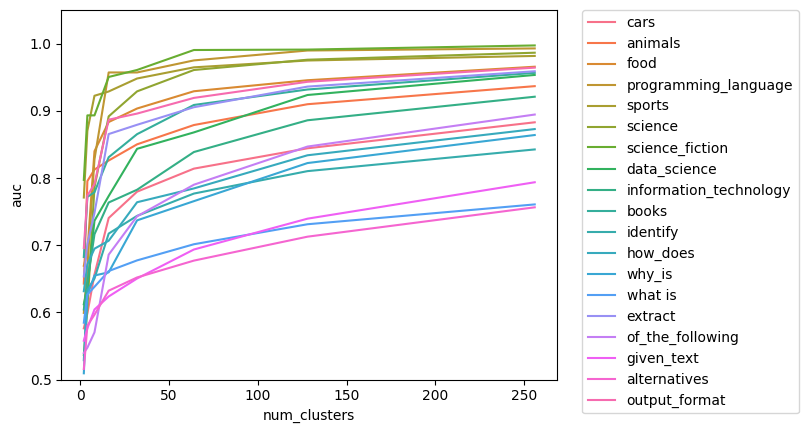

In [3]:
dendro = get_cluster_dendrogram(instruction_data['unit_vector'])

pattern_flags = find_pattern_flags_in_text(instruction_data['instruction'], patterns)

if os.path.exists(MODELS_FILE):
    my_models = pickle.load(open(MODELS_FILE, "rb"))
else:
    my_models = train_pattern_models(instruction_data['instruction_vector'], pattern_flags, verbose=True)
    pickle.dump(my_models, open(MODELS_FILE, "wb"))
    
pattern_scores = get_model_scores_for_vectors(instruction_data['instruction_vector'], my_models)

mean_xval_auc = get_model_mean_xval_auc(my_models)

cluster_assignment_df = get_cluster_assignments(dendro)

# cluster_rocs_step1 = get_cluster_rocs(pattern_flags, cluster_assignment_df)  # TO DO: combine these two functions!!!
# cluster_roc_df = extract_cluster_roc_df(cluster_rocs_step1)

cluster_roc_df = get_cluster_performance_df(cluster_assignment_df, pattern_flags)

plot_cluster_aucs(cluster_roc_df)


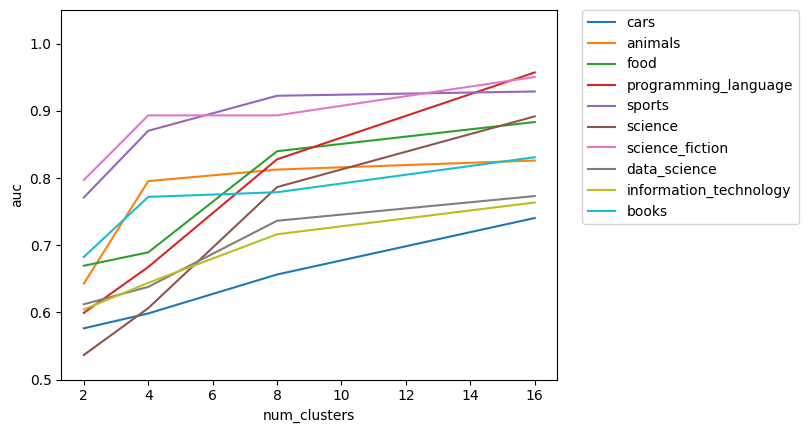

In [4]:
domain_flags = ['cars', 'animals', 'food', 'programming_language', 'sports', 'science',
       'science_fiction', 'data_science', 'information_technology', 'books']

framework_flags = ['identify', 'how_does', 'why_is', 'what is', 'extract',
       'of_the_following', 'given_text', 'alternatives', 'output_format']


abcd = cluster_roc_df[ [cc in ['A', 'B', 'C', 'D'] for cc in cluster_roc_df['cluster_col'] ] ]

plot_cluster_aucs(abcd[ [f in domain_flags for f in abcd['flag']] ])

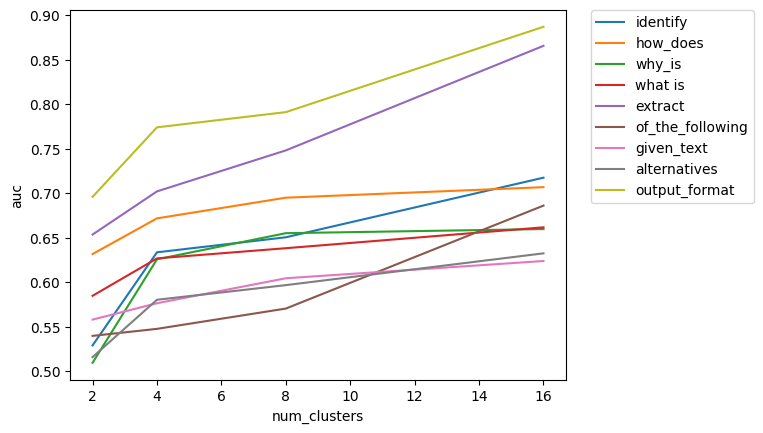

In [5]:


my_cluster_aucs = abcd[ [f in framework_flags for f in abcd['flag']] ]

ax = sns.lineplot(x='num_clusters', y='auc', data=my_cluster_aucs, hue='flag')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
# ax.set_xscale('log')



8 ['0.576', '0.598', '0.656', '0.740', '0.780', '0.814', '0.844', '0.883']


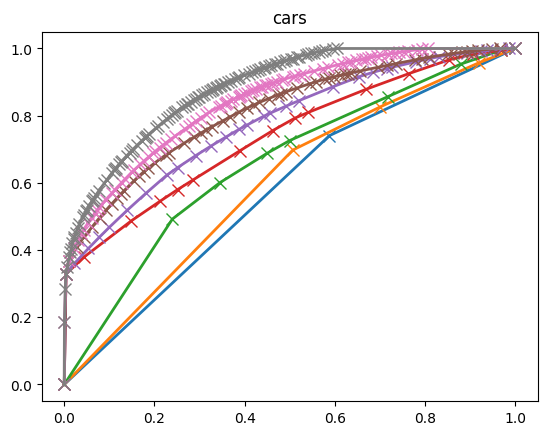

In [6]:
plot_aspect_roc_curves('cars', cluster_roc_df)

8 ['0.643', '0.795', '0.813', '0.826', '0.850', '0.879', '0.910', '0.937']


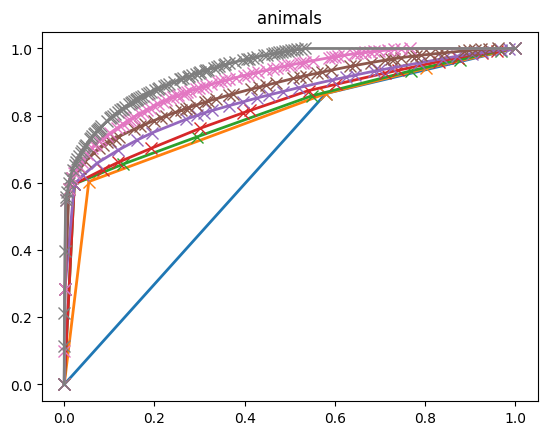

In [7]:
plot_aspect_roc_curves('animals', cluster_roc_df)

8 ['0.599', '0.668', '0.828', '0.957', '0.957', '0.975', '0.990', '0.993']


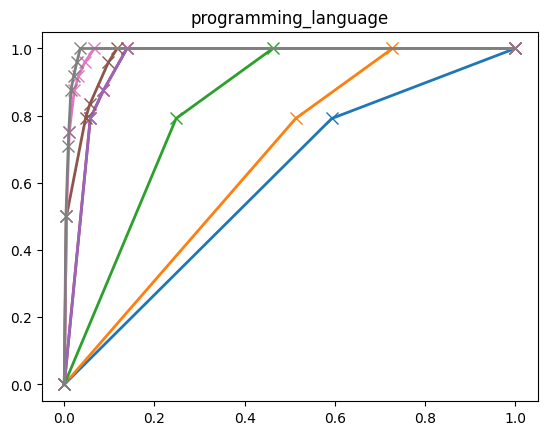

In [8]:
plot_aspect_roc_curves('programming_language', cluster_roc_df)

# Where is the red curve?

8 ['0.797', '0.893', '0.893', '0.950', '0.961', '0.990', '0.991', '0.997']


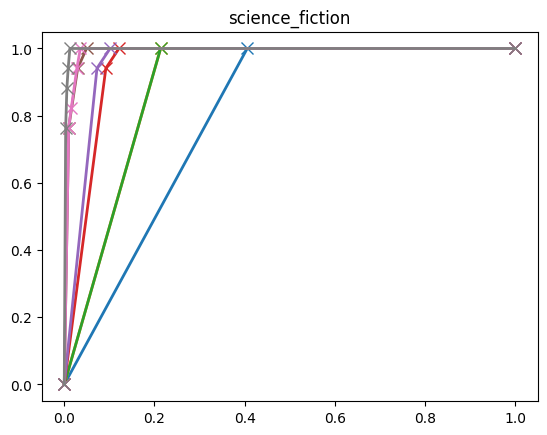

In [9]:
plot_aspect_roc_curves('science_fiction', cluster_roc_df) # science

8 ['0.516', '0.580', '0.597', '0.632', '0.652', '0.677', '0.713', '0.756']


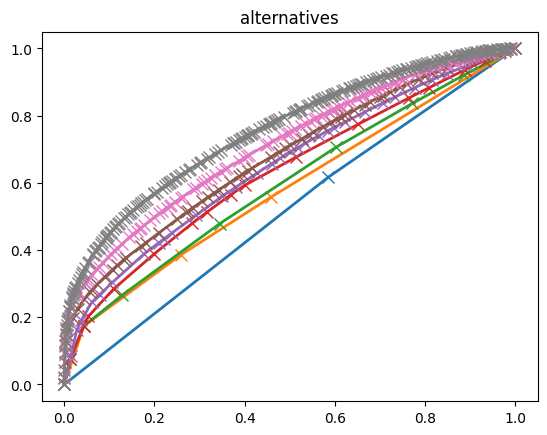

In [10]:
plot_aspect_roc_curves('alternatives', cluster_roc_df)

8 ['0.696', '0.774', '0.791', '0.887', '0.896', '0.919', '0.943', '0.964']


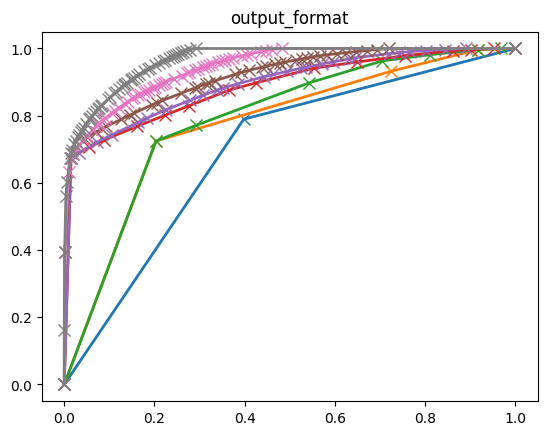

In [11]:
plot_aspect_roc_curves('output_format', cluster_roc_df)

# Re-weight embeddings

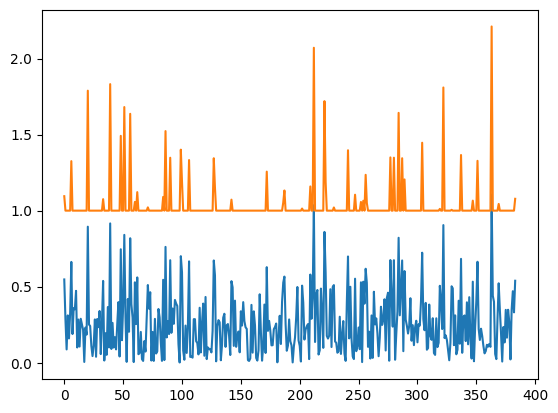

In [12]:
mean_framework_coefs = np.mean([ my_models[flag].coef_[0] for flag in framework_flags ], axis=0)
plt.plot(np.abs(mean_framework_coefs))

adjustment_vector = [ 1 if x<1 else x for x in 2*np.abs(mean_framework_coefs) ]

plt.plot(adjustment_vector)

In [13]:
# my_modifier = my_models['animals'].coef_.astype(FP_TYPE)

# projection = np.array([ get_projection(emb, mean_framework_coefs) for emb in instruction_data['unit_vector'] ])
# projection.shape  # (15011, 384)

In [14]:
def plot_cluster_aucs(my_cluster_aucs, title='', file=''):
    """
    Plot cluster AUC vs. cluster size, from the data returned by 'extract_cluster_aucs'

    usage:
        cluster_rocs = get_cluster_performance_df(cluster_assignment_df, pattern_flags)
        plot_cluster_aucs(cluster_aucs)

    """
    ax = sns.lineplot(x='num_clusters', y='auc', data=my_cluster_aucs, hue='flag')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.title(title)
    plt.ylim(0.5, 1.05)
    ax.set_xscale('log')
    if file != '':
        plt.savefig(file)

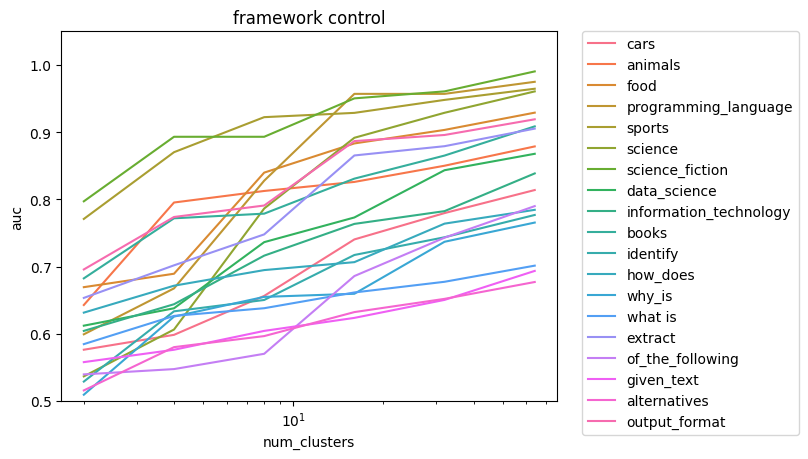

In [15]:
ctl_dendro = get_cluster_dendrogram(instruction_data['unit_vector'])

ctl_cluster_assignment_df = get_cluster_assignments(ctl_dendro, num_slices=6)

ctl_cluster_roc_df = get_cluster_performance_df(ctl_cluster_assignment_df, pattern_flags)

plot_cluster_aucs(ctl_cluster_roc_df, title="framework control", file='framework_control.png')

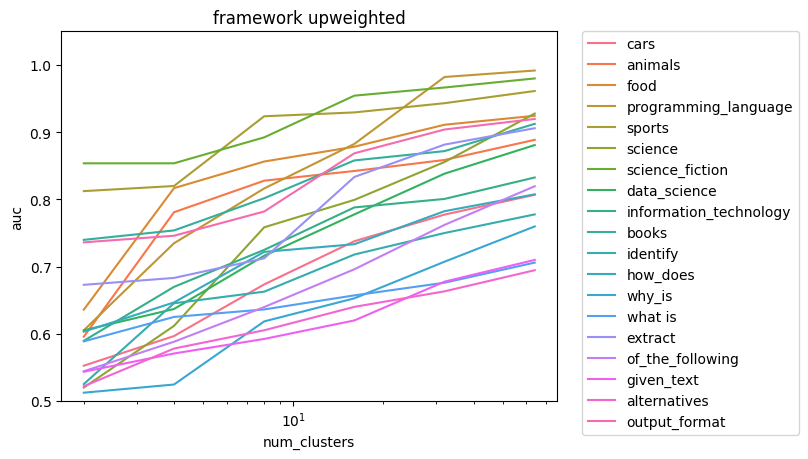

In [16]:
# alpha = 1
# upweighted_embedding = [emb + alpha * prj for emb, prj in zip(instruction_data['unit_vector'], projection)]

upweighted_embedding = [emb * adjustment_vector for emb in instruction_data['unit_vector'] ]

uw_dendro = get_cluster_dendrogram(upweighted_embedding)

uw_cluster_assignment_df = get_cluster_assignments(uw_dendro, num_slices=6)

uw_cluster_roc_df = get_cluster_performance_df(uw_cluster_assignment_df, pattern_flags)

plot_cluster_aucs(uw_cluster_roc_df, title="framework upweighted", file='framework_upweighted_adj.png')

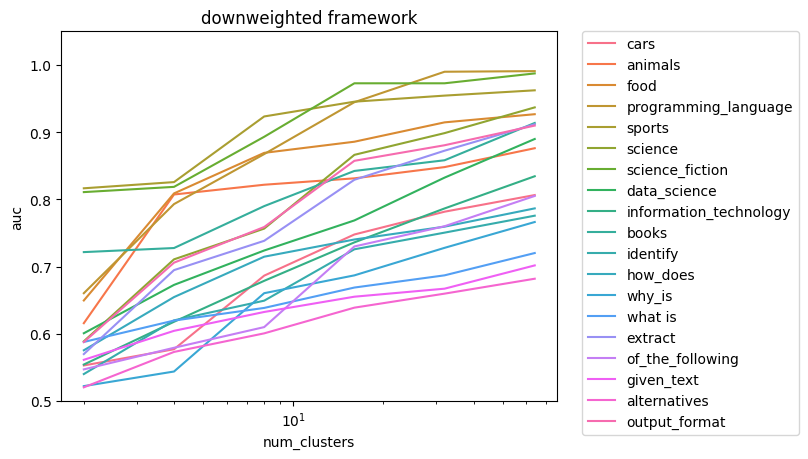

In [17]:
# alpha = -1

downweighted_embedding = [emb / adjustment_vector for emb in instruction_data['unit_vector']]
                        
dw_dendro = get_cluster_dendrogram(downweighted_embedding)

dw_cluster_assignment_df = get_cluster_assignments(dw_dendro, num_slices=6)

dw_cluster_roc_df = get_cluster_performance_df(dw_cluster_assignment_df, pattern_flags)

plot_cluster_aucs(dw_cluster_roc_df, title="downweighted framework", file='framework_downweighted_adj_inv.png')

6 ['0.596', '0.781', '0.828', '0.842', '0.859', '0.889']


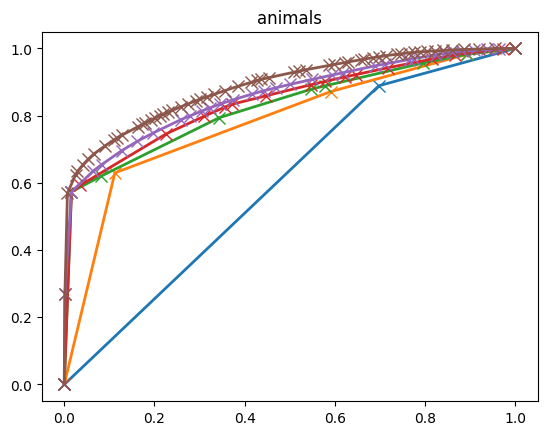

In [19]:
plot_aspect_roc_curves('animals', uw_cluster_roc_df)

6 ['0.643', '0.795', '0.813', '0.826', '0.850', '0.879']


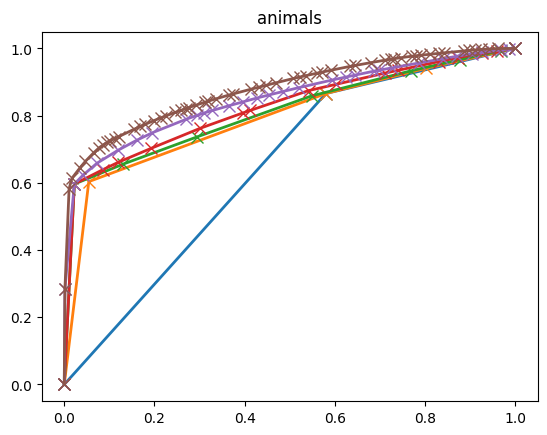

In [21]:
plot_aspect_roc_curves('animals', ctl_cluster_roc_df)

6 ['0.616', '0.807', '0.822', '0.831', '0.848', '0.876']


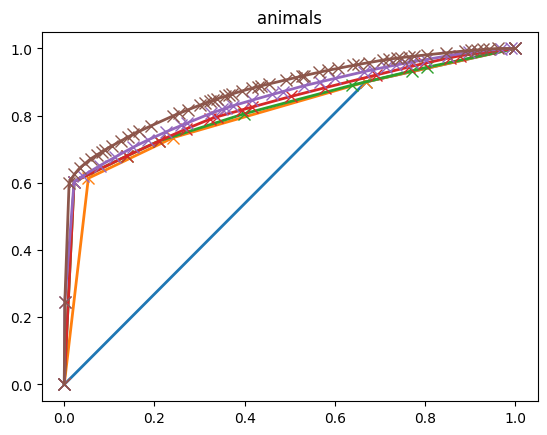

In [22]:
plot_aspect_roc_curves('animals', dw_cluster_roc_df)

# In Progress

## Improved strip plots

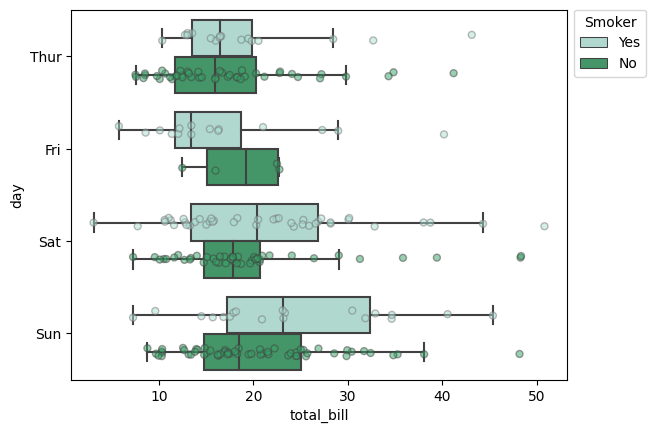

In [31]:
import seaborn as sns

# load the dataframe
tips = sns.load_dataset('tips')

common_params = {'y': "day", 'x': "total_bill", 'hue': "smoker", 'data': tips, 'palette': "BuGn"}
ax = sns.boxplot(fliersize=0, **common_params)

# add stripplot with dodge=True
sns.stripplot(dodge=True, ax=ax, ec='k', linewidth=1, alpha=0.5, **common_params)

# remove extra legend handles and place legend outside bbox
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title='Smoker', bbox_to_anchor=(1, 1.02), loc='upper left')


(-0.05, 1.05)

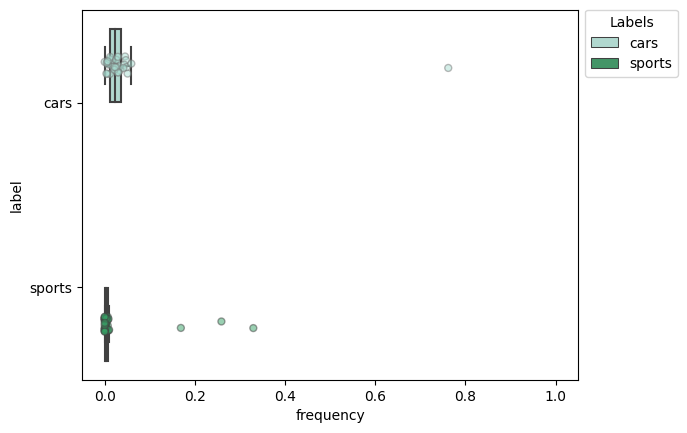

In [30]:

clusterings = cluster_assignment_df[['E', 'F']]
flags_df = pattern_flags[['cars', 'sports']]
cfdf = clusterings.join(flags_df)

ccol = clusterings.columns[0]
cluster_frequencies = cfdf[[ccol, *flags_df.columns]].groupby(ccol).mean().reset_index()

cf_long = pd.melt(cluster_frequencies, id_vars=ccol, var_name='label', value_name='frequency')
cf_long

common_params = {'y': "label", 'x': "frequency", 'hue': "label", 'data': cf_long, 'palette': "BuGn"}
ax = sns.boxplot(fliersize=0, **common_params)

# add stripplot with dodge=True
sns.stripplot(dodge=True, ax=ax, ec='k', linewidth=1, alpha=0.5, **common_params)

# remove extra legend handles and place legend outside bbox
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], labels[:2], title='Labels', bbox_to_anchor=(1, 1.02), loc='upper left')

plt.xlim(-0.05,1.05)


## Entropy

In [ ]:


def plot_cluster_performance_df(df):
    """
    Plot of mean entropy vs AUC.
    """
    xcol = 'mean_entropy'
    ycol = 'auc'
    ax = sns.scatterplot(data=df, x=xcol, y=ycol, hue='flag', size='flag', sizes=(150, 150))
    # add text annotations
    for i in range(len(df)):
         plt.text(df[xcol][i], df[ycol][i], df['cluster_col'][i], 
                  horizontalalignment='center', verticalalignment='center', 
                  size='medium', color='white', weight='semibold')
    ax.legend(handles[0:2], labels, title='Labels', bbox_to_anchor=(1, 1.02), loc='upper left')
    

In [ ]:
# get_performance_for_clustering(cluster_assignment_df['E'], pattern_flags['sports'])

cluster_performance_df = get_cluster_performance_df(cluster_assignment_df, pattern_flags)


plot_cluster_performance_df(cluster_performance_df)

## Upgrading ROC curves

In [ ]:

# Modify `plot_aspect_roc_curves` to use a specified color spectrum. We want to represent multiple sets of ROC curves in the same plot with
# a distinguishable spectrum for each plot.
# Order clusters by p-value from binomial distribution?

reds = hue_spectrum(8, hue=0, saturation=1)
print("reds =", reds)

blues = hue_spectrum(8, hue=2/3, saturation=1)
print("blues =", blues)

In [54]:
# Rank clusters by cumulative probability of seeing at least that many positives.
# For each cluster, n = size, p = overall prevalence of positive labels

from scipy.stats import binom

n = 10    # number of trials
p = 0.5  # probability of success in each trial
x = [k for k in range(n+1)] # probability of this many successes or fewer

pdf = pd.DataFrame({'successes': x, 'pmf': binom.pmf(x, n, p), 'cdf': binom.cdf(x, n, p)})
pdf['cdf2'] = np.cumsum(pdf['pmf'])
pdf
# binom.cdf(0, n, p)
# 0.5**8 # 0.00390625

,successes,pmf,cdf,cdf2
0,0,0.000977,0.000977,0.000977
1,1,0.009766,0.010742,0.010742
2,2,0.043945,0.054688,0.054688
3,3,0.117187,0.171875,0.171875
4,4,0.205078,0.376953,0.376953
5,5,0.246094,0.623047,0.623047
6,6,0.205078,0.828125,0.828125
7,7,0.117187,0.945312,0.945312
8,8,0.043945,0.989258,0.989258
9,9,0.009766,0.999023,0.999023


0.00390625

In [ ]:
# text_col = 'instruction'
# for pattern_name in patterns:
#     flag_vector = [bool(regex.search(patterns[pattern_name], sent, regex.IGNORECASE)) for sent in instruction_data[text_col]]
#     instruction_data[f"{pattern_name}_flag"] = flag_vector
#     print(pattern_name, sum(flag_vector))

# class WeightableClustering():
#     """A single text vector can have multiple embeddings, each of which can be used for multiple clusterings."""
#     def __init__(self, text_list):
#         self.text = text_list
#         self.embeddings = {}    # key = name, value=list of embedding vectors
#         self.ClusterTrees = {}  # key = descriptor, value = ClusterTree object

#     def add_embedding(self, embedding_name, embedding_obj):
#         self.embeddings[embedding_name] = embedding_obj

# class ClusterTree():

#     def __init__(self, text_list):
#         self.embedding = []   # embedding vectors
#         self.dendrograms = {}  # key = descriptor, value = ClusterTree object

# from scipy.cluster.hierarchy import ward, fcluster
# from scipy.spatial.distance import pdist
# import math

# # cluster by the sentence vectors
# vector_list = instruction_data['unit_vector'].tolist()
# D = pdist(vector_list, metric='cosine') # condensed pairwise distance matrix
# dendro = ward(D) # linkage matrix representing a dendrogram [cl1, cl2, distance, size of merged cluster)

# cluster_assignments = [] # list of dicts: {num_cluters, cluster_ids}
# for num_clusters in [10, 20, 40, 80, 160, 320]:
#     cluster_ids = fcluster(dendro, num_clusters, criterion='maxclust')
#     cluster_assignments.append({'num_clusters': num_clusters, 'cluster_ids': cluster_ids})

# zdf = pd.DataFrame(z, columns=['c1', 'c2', 'd', 'n'])
# zdf[zdf['c1'] < 2]